In [9]:
import utils as u

import os
import pickle

import time
import numpy as np

from matplotlib import pyplot as plt

import mne

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks, resample
from pycrostates.io import ChData
from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)

In [3]:
import pycrostates
pycrostates.__version__

'0.5.0'

In [4]:
import warnings

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

## Paths

In [6]:
# Define the path to the main data folder where the raw eeg can be found
DATA_FOLDER = 'E:\DATA_FOLDER'

# Define the path to the main folder where the preprocessed data will be stored
DATA_PREPROCESS = 'DATA_PREPROCESSED'
# Crear la carpeta para el paciente en la carpeta de destino
os.makedirs(DATA_PREPROCESS, exist_ok=True)

## Group-level analysis from individual clusters

In [ ]:
individual_cluster_centers = []

# Recording time required for the preprocessing
t = time.time()

# Loop through subject folders
for subject in os.listdir(DATA_FOLDER):
    print(subject)

    # Construct the full path to the subject folder
    subject_path = os.path.join(DATA_FOLDER, subject)

    # Check if it's a directory
    if os.path.isdir(subject_path):
        #print(f"\nProcessing data for subject {subject}...")
        
        # Construct the path to the BrainVision files folder
        rseeg_folder = os.path.join(subject_path, 'RSEEG')
        
        # Check if the RSEEG folder exists
        if os.path.exists(rseeg_folder):

            vhdr_files = [file for file in os.listdir(rseeg_folder) if file.endswith('.vhdr')]
                        
            # Check if a .vhdr file is found
            if vhdr_files:
                
                # Construct the full path to the .vhdr file
                vhdr_path = os.path.join(rseeg_folder, vhdr_files[0])
                
                # Read the BrainVision files
                try:
                    raw = mne.io.read_raw_brainvision(vhdr_path, eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)
                    raw.set_montage("standard_1020")
                except Exception as e:
                    print(f"Error reading files for subject {subject}: {e}")

                # Extract GFP peaks from the preprocessed signal
                gfp_peaks = extract_gfp_peaks(u.preprocessing(raw))
                
                # subject level clustering
                ModK = ModKMeans(n_clusters=5, random_state=42)
                ModK.fit(gfp_peaks, n_jobs=2)
                individual_cluster_centers.append(ModK.cluster_centers_)

            else:
                print(f"No .vhdr file found for subject {subject}.")
        else:
            print(f"RSEEG folder not found for subject {subject}.")
    else:
        print(f"There is no subject {subject}.")


group_cluster_centers = np.vstack(individual_cluster_centers).T
group_cluster_centers = ChData(group_cluster_centers, ModK.info)

# group level clustering
ModK = ModKMeans(n_clusters=3, random_state=42)
ModK.fit(group_cluster_centers, n_jobs=2)

print('Tiempo de preprocesado', time.time() - t)

## Group-level analysis from individual GFP peaks

Reading C:\Users\enriq\pycrostates_data\PREPROCESSED_LEMON\sub-010020_EO.fdt
Reading 0 ... 104402  =      0.000 ...   417.608 secs...
Creating RawArray with float64 data, n_channels=61, n_times=104403
    Range : 0 ... 104402 =      0.000 ...   417.608 secs
Ready.
Location for this channel is unknown; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 2 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Reading C:\Users\enriq\pycrostates_data\PREPROCESSED_LEMON\sub-010021_EO.fdt
Reading 0 ... 114834  =      0.000 ...   459.336 secs...
Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Reading C:\Users\enriq\pycrostates_data\PREPROCESSED_LEMON\sub-010022_EO.fdt
Reading 0 ... 118241  =      0.000 ...   472.964 secs...
Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Reading C:\Users\enriq\pycrostates_data\PREPROCESSED_LEMON\sub-010023_EO.fdt
Reading 0 ... 105067  =      0.000 ...   420.268 secs...
Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Reading C:\Users\enriq\pycrostates_data\PREPROCESSED_LEMON\sub-010024_EO.fdt
Reading 0 ... 118118  =      0.000 ...   472.472 secs...
Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


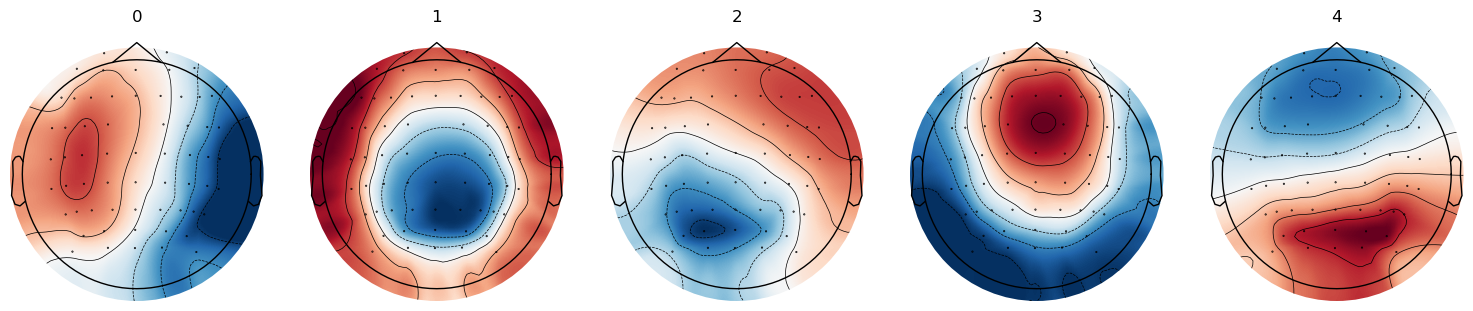

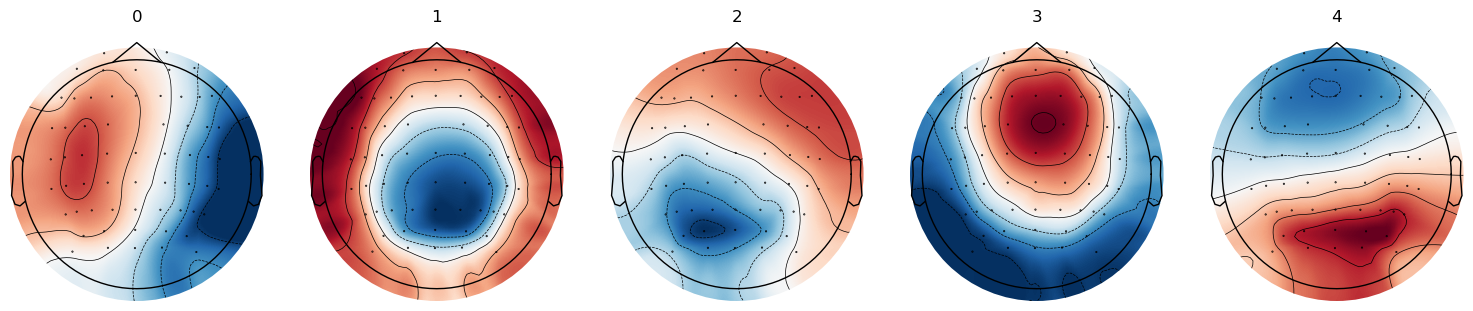

In [21]:
condition = "EO"
subject_ids = ["010020", "010021", "010022", "010023", "010024"]

individual_gfp_peaks = list()
for subject_id in subject_ids:
    # load Data
    raw_fname = lemon.data_path(subject_id=subject_id, condition=condition)
    raw = read_raw_eeglab(raw_fname, preload=True)
    raw = lemon.standardize(raw)
    raw.pick("eeg")
    raw.crop(0, 30)  # crop the dataset to speed up computation
    raw.set_eeg_reference("average")
    # extract GFP peaks
    gfp_peaks = extract_gfp_peaks(raw)
    # equalize peak number across subjects by resampling
    gfp_peaks = resample(
        gfp_peaks, n_resamples=1, n_samples=880, random_state=42
    )[0]
    individual_gfp_peaks.append(gfp_peaks.get_data())

individual_gfp_peaks = np.hstack(individual_gfp_peaks)
individual_gfp_peaks = ChData(individual_gfp_peaks, raw.info)

# group level clustering
ModK = ModKMeans(n_clusters=5, random_state=42)
ModK.fit(individual_gfp_peaks, n_jobs=2)
ModK.plot()

In [13]:
individual_gfp_peaks = []

# Recording time required for the preprocessing
t = time.time()

# Loop through subject folders
for subject in os.listdir(DATA_FOLDER):
    print(subject)

    # Construct the full path to the subject folder
    subject_path = os.path.join(DATA_FOLDER, subject)

    # Check if it's a directory
    if os.path.isdir(subject_path):
        #print(f"\nProcessing data for subject {subject}...")
        
        # Construct the path to the BrainVision files folder
        rseeg_folder = os.path.join(subject_path, 'RSEEG')
        
        # Check if the RSEEG folder exists
        if os.path.exists(rseeg_folder):

            vhdr_files = [file for file in os.listdir(rseeg_folder) if file.endswith('.vhdr')]
                        
            # Check if a .vhdr file is found
            if vhdr_files:
                
                # Construct the full path to the .vhdr file
                vhdr_path = os.path.join(rseeg_folder, vhdr_files[0])
                
                # Read the BrainVision files
                try:
                    raw = mne.io.read_raw_brainvision(vhdr_path, eog=('VEOG',), preload=True, misc='auto', scale=1, verbose=None)
                    raw.set_montage("standard_1020")
                except Exception as e:
                    print(f"Error reading files for subject {subject}: {e}")

                # Extract GFP peaks from the preprocessed signal
                gfp_peaks = extract_gfp_peaks(u.preprocessing(raw))
                
                # equalize peak number across subjects by resampling
                gfp_peaks = resample(gfp_peaks, n_resamples=1, n_samples=880, random_state=42)[0]
                individual_gfp_peaks.append(gfp_peaks.get_data())

            else:
                print(f"No .vhdr file found for subject {subject}.")
        else:
            print(f"RSEEG folder not found for subject {subject}.")
    else:
        print(f"There is no subject {subject}.")


individual_gfp_peaks = np.hstack(individual_gfp_peaks)
individual_gfp_peaks = ChData(individual_gfp_peaks, raw.info)

# group level clustering
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(individual_gfp_peaks, n_jobs=2)

print('Tiempo de preprocesado', time.time() - t)

sub-010002
Extracting parameters from E:\DATA_FOLDER\sub-010002\RSEEG\sub-010002.vhdr...
Setting channel info structure...
Reading 0 ... 2554999  =      0.000 ...  1022.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using EOG channel: VEOG
EOG channel index for this subject is: [16]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel VEOG for blink detection
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 20.25 Hz)
- Filter length: 25000 samples (10.000 s)

Now detecting blinks and genera

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Found 62 significant peaks
Number of EOG events detected: 62
Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 62 events and 2501 original time points ...
0 bad epochs dropped
Fitting ICA to data using 61 channels (please be patient, this may take a while)


KeyboardInterrupt: 

In [ ]:
ModK.plot()
plt.show()

In [23]:
ModK.reorder_clusters(order=[0, 1, 3, 2])
ModK.rename_clusters(new_names=["A", "B", "C", "D"])

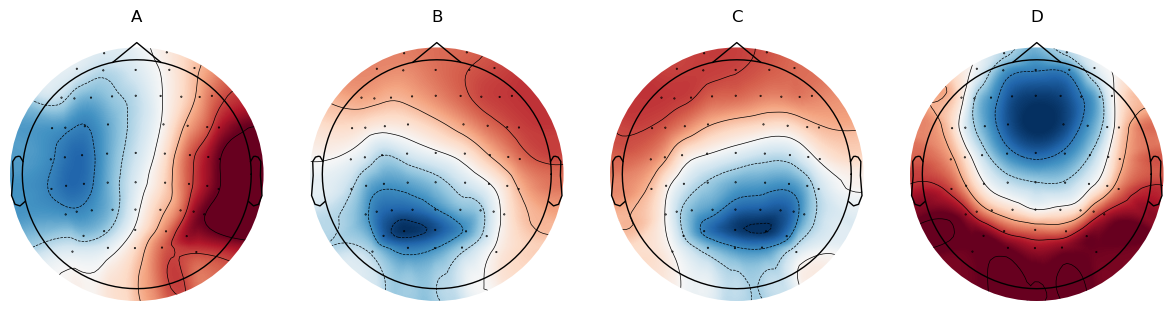

In [24]:
ModK.plot()
plt.show()

In [52]:
# Save
with open('E:\microstates.pickle', 'wb') as f:
    pickle.dump(ModK, f)

## Obtaining required clusters

In [7]:
model = 'E:\Microestados\m5_2500.pickle'

# Load
with open(model, 'rb') as f:
    ModK = pickle.load(f)

In [33]:
# Extract the current cluster centers
cluster_centers = ModK.cluster_centers_

# Select the first 4 cluster centers
new_cluster_centers = cluster_centers[:4]

new_cluster_centers = np.vstack(new_cluster_centers).T
new_cluster_centers = ChData(new_cluster_centers, ModK.info)

# Create a new `ModKMeans` object with the new cluster centers
new_ModK = ModKMeans(n_clusters=4,)
new_ModK.fit(new_cluster_centers, n_jobs=2)

In [37]:
new_ModK.reorder_clusters(order=[3, 2, 0, 1])
new_ModK.rename_clusters(new_names=["A", "B", "C", "D"])

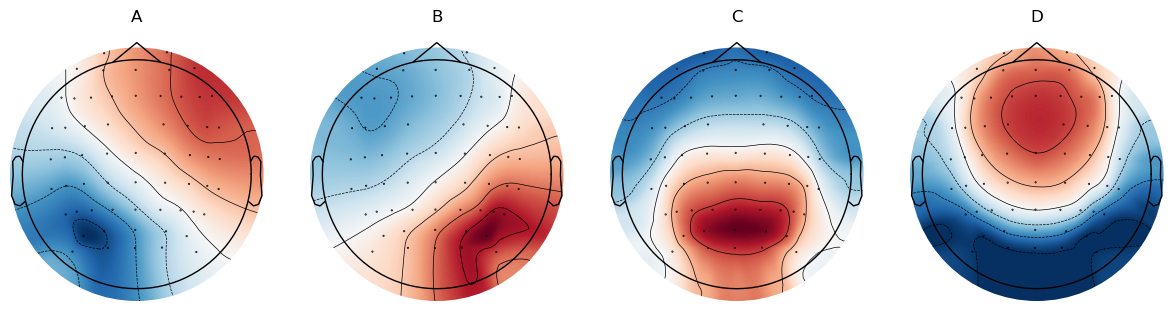

In [38]:
new_ModK.plot()
plt.show()

In [53]:
ModK

Method,ModKMeans
Fit,100 initializations on 639 samples
Cluster centers,3
GEV,73.37 %
Cluster centers names,"AB, C, D"
Channels,61 EEG


In [10]:
ModK

Method,ModKMeans
Fit,100 initializations on 852 samples
Cluster centers,4
GEV,73.18 %
Cluster centers names,"A, B, C, D"
Channels,61 EEG


In [12]:
ModK

Method,ModKMeans
Fit,100 initializations on 1065 samples
Cluster centers,5
GEV,73.10 %
Cluster centers names,"A, B, C, D, E"
Channels,61 EEG


In [9]:
ModK

Method,ModKMeans
Fit,100 initializations on 1278 samples
Cluster centers,6
GEV,74.45 %
Cluster centers names,"A, B, C, D, E, F"
Channels,61 EEG


In [15]:
ModK

Method,ModKMeans
Fit,100 initializations on 1491 samples
Cluster centers,7
GEV,74.24 %
Cluster centers names,"A, B, C, D, E, F, G"
Channels,61 EEG


In [21]:
ModK

Method,ModKMeans
Fit,100 initializations on 1704 samples
Cluster centers,8
GEV,75.35 %
Cluster centers names,"A, B, C, D, E, F, G, H"
Channels,61 EEG


## Evaluating clustering fits

In [9]:
cluster_numbers = range(3, 10)
scores = {
    "Silhouette": np.zeros(len(cluster_numbers)),
    "Calinski-Harabasaz": np.zeros(len(cluster_numbers)),
    "Dunn": np.zeros(len(cluster_numbers)),
    "Davies-Bouldin": np.zeros(len(cluster_numbers)),
}

In [10]:
# Directory containing the files
directory = r"H:\CSIC\Microstates"

# Range of cluster numbers to evaluate
cluster_numbers = range(3, 10)

# Initialize scores dictionary
scores = {
    "Silhouette": np.zeros(len(cluster_numbers)),
    "Calinski-Harabasz": np.zeros(len(cluster_numbers)),
    "Dunn": np.zeros(len(cluster_numbers)),
    "Davies-Bouldin": np.zeros(len(cluster_numbers)),
}

# Function to process each file and evaluate clusters
def process_file(filepath):
    try:
        # Open the pickle file
        with open(filepath, 'rb') as file:
            data = pickle.load(file)
        
        print(f"Processing file: {filepath}")
        
        # Assuming data is a NumPy array or can be converted to one
        for i, num_clusters in enumerate(cluster_numbers):
            # Perform clustering (assuming data can be clustered, e.g., KMeans)
            kmeans = KMeans(n_clusters=num_clusters, random_state=42)
            labels = kmeans.fit_predict(data)
            
            # Calculate evaluation metrics using pycrostates
            scores["Silhouette"][i] += silhouette_score(data, labels)
            scores["Calinski-Harabasz"][i] += calinski_harabasz_score(data, labels)
            scores["Dunn"][i] += dunn_score(data, labels)
            scores["Davies-Bouldin"][i] += davies_bouldin_score(data, labels)
    
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")

# Iterate over all files in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    
    # Check if the path is a file (not a directory)
    if os.path.isfile(filepath):
        process_file(filepath)

Processing file: E:\Microestados\m3_2500.pickle
Error processing file E:\Microestados\m3_2500.pickle: name 'KMeans' is not defined
Processing file: E:\Microestados\m4_2500.pickle
Error processing file E:\Microestados\m4_2500.pickle: name 'KMeans' is not defined
Processing file: E:\Microestados\m5_2500.pickle
Error processing file E:\Microestados\m5_2500.pickle: name 'KMeans' is not defined
Processing file: E:\Microestados\m6_2500.pickle
Error processing file E:\Microestados\m6_2500.pickle: name 'KMeans' is not defined
Processing file: E:\Microestados\m7_2500.pickle
Error processing file E:\Microestados\m7_2500.pickle: name 'KMeans' is not defined
Processing file: E:\Microestados\m8_2500.pickle
Error processing file E:\Microestados\m8_2500.pickle: name 'KMeans' is not defined
Processing file: E:\Microestados\microstates.pickle
Error processing file E:\Microestados\microstates.pickle: name 'KMeans' is not defined


In [ ]:
scores["Silhouette"][-1] = silhouette_score(ModK)
scores["Calinski-Harabasaz"][-1] = calinski_harabasz_score(ModK)
scores["Dunn"][-1] = dunn_score(ModK)
scores["Davies-Bouldin"][-1] = davies_bouldin_score(ModK)